In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import textblob
#cleaning
import re
import nltk



In [157]:
#download corpus used to train naive bayes classifier
nltk.download('movie_reviews')

data = pd.read_csv("floks.csv")
data

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\Matt\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


,text,postType,createdAt
0,Happy Friday Flok!,SCU,Fri Jul 30 2021 12:18:12 GMT-0700 (Pacific Day...
1,Let’s fucking ride Broncos 😤,SCU,Thu Aug 12 2021 16:30:21 GMT-0700 (Pacific Day...
2,Welcome to Flok!!,SCU,Thu Aug 12 2021 16:35:42 GMT-0700 (Pacific Day...
3,We’re all in agreement sig pi is sus right,SCU,Thu Aug 12 2021 16:47:38 GMT-0700 (Pacific Day...
4,Every girl on women’s soccer from last year is...,SCU,Thu Aug 12 2021 16:50:01 GMT-0700 (Pacific Day...
...,...,...,...
9831,this app is mostly dumb obv but i’m really gla...,SCU,Sat Jan 22 2022 00:51:16 GMT-0800 (Pacific Sta...
9832,Did anyone else see some haunted ass shit toni...,SCU,Sat Jan 22 2022 00:51:34 GMT-0800 (Pacific Sta...
9833,honestly how does sig pi live with themselves?...,SCU,Sat Jan 22 2022 00:51:40 GMT-0800 (Pacific Sta...
9834,FUCK SIG PI,SCU,Sat Jan 22 2022 00:51:40 GMT-0800 (Pacific Sta...


In [158]:
#remove irrelevant column
data.drop(['postType', 'createdAt'], axis=1, inplace=True)
data

,text
0,Happy Friday Flok!
1,Let’s fucking ride Broncos 😤
2,Welcome to Flok!!
3,We’re all in agreement sig pi is sus right
4,Every girl on women’s soccer from last year is...
...,...
9831,this app is mostly dumb obv but i’m really gla...
9832,Did anyone else see some haunted ass shit toni...
9833,honestly how does sig pi live with themselves?...
9834,FUCK SIG PI


In [159]:
# remove emojis and special characters
data = data.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

# clean text
def clean_text(text): 
    pat1 = r'@[^ ]+'
    pat2 = r'\'s'                     
    pat3 = r'\#\w+'                     
    pat4 = r'&amp '                     
    pat5 = r'[^A-Za-z\s]'              
    combined_pat = r'|'.join((pat1, pat2,pat3,pat4,pat5))
    text = re.sub(combined_pat,'',text).lower()
    return text.strip()

data["cleaned_floks"] = data["text"].apply(clean_text)
data



,text,cleaned_floks
0,Happy Friday Flok!,happy friday flok
1,Lets fucking ride Broncos,lets fucking ride broncos
2,Welcome to Flok!!,welcome to flok
3,Were all in agreement sig pi is sus right,were all in agreement sig pi is sus right
4,Every girl on womens soccer from last year is ...,every girl on womens soccer from last year is ...
...,...,...
9831,this app is mostly dumb obv but im really glad...,this app is mostly dumb obv but im really glad...
9832,Did anyone else see some haunted ass shit toni...,did anyone else see some haunted ass shit toni...
9833,honestly how does sig pi live with themselves?...,honestly how does sig pi live with themselves ...
9834,FUCK SIG PI,fuck sig pi


In [160]:
data.drop(['text'], axis=1, inplace=True)

# remove stop words
stop_words = nltk.corpus.stopwords.words('english')
data['cleaned_floks'] = data['cleaned_floks'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
data.head

#keep track of total quantity of positive, negative, and neutral floks for each classifier
bayes_num_pos = 0
bayes_num_neg = 0
pattern_num_pos = 0
pattern_num_neg = 0
pattern_num_neutral = 0

#initialize classifiers
bayes_clf = textblob.Blobber(analyzer=textblob.sentiments.NaiveBayesAnalyzer())
pattern_clf = textblob.Blobber()

#classify the dta using both analyzers
for index,row in data.iterrows():
    sent = bayes_clf(row['cleaned_floks']).sentiment
    data.loc[index,'bayes_sentiment'] = sent[0]
    data.loc[index,'bayes_p_pos'] = sent[1]
    data.loc[index,'bayes_p_neg'] = sent[2]

    if sent[0] == 'pos':
        bayes_num_pos +=1
    else:
        bayes_num_neg += 1


    pattern_sent = pattern_clf(row['cleaned_floks']).sentiment
    data.loc[index,'pattern_polarity'] = pattern_sent[0]
    data.loc[index,'pattern_subjectivity'] = pattern_sent[1]

    if pattern_sent[0] == 0:
        pattern_num_neutral += 1
    elif pattern_sent[0] > 0:
        pattern_num_pos +=1
    else:
        pattern_num_neg +=1

In [130]:
data
#look at overall numbers of positive, negative, and neutral posts
print('naive bayes analyzer:\nnumber of positive floks: %d \nnumber of negative floks: %d'%(bayes_num_pos,bayes_num_neg))
print('pattern analyzer:\nnumber of positive floks: %d \nnumber of negative floks: %d\nnumber of neutral floks: %d'%(pattern_num_pos,pattern_num_neg,pattern_num_neutral))
#save the results, just in case
data.to_csv('flok_sentiments.csv')

naive bayes analyzer:
number of positive floks: 5417 
number of negative floks: 4419
pattern analyzer:
number of positive floks: 2320 
number of negative floks: 1864
number of neutral floks: 5652


In [144]:
#looks up individual word in corpus, prints out data about floks containing the word
def get_word_sentiment(word):

    bayes_pos = 0 
    bayes_neg = 0 
    pat_pos = 0 
    pat_neg = 0
    count = 0
    polarity_count = 0
    subj_count = 0

    for index,row in data.iterrows():
        if word in row['cleaned_floks'].split():

            count +=1
            polarity_count += row['pattern_polarity']
            subj_count += row['pattern_subjectivity']

            if row['bayes_sentiment'] == 'pos':
                bayes_pos += 1
            elif row['bayes_sentiment'] == 'neg':
                bayes_neg += 1

            if row['pattern_polarity'] > 0:
                pat_pos += 1
            elif row['pattern_polarity'] < 0:
                pat_neg += 1
    polarity_count = polarity_count/count
    subj_count = subj_count/count        
    print('sentiment for %s:\n    Naive Bayes:\n        number positive: %d number negative: %d\n    Pattern Analyzer:\n        number positive: %d number negative: %d'%(word,bayes_pos,bayes_neg,pat_pos,pat_neg))
    print('    mean polarity: %r mean subjectivity: %r'%(polarity_count,subj_count))

In [145]:
#look at sentiment for a few keywords related to the school
get_word_sentiment('benson')
get_word_sentiment('roommate')
get_word_sentiment('swig')
get_word_sentiment('frat')
get_word_sentiment('school')

sentiment for benson:
    Naive Bayes:
        number positive: 266 number negative: 79
    Pattern Analyzer:
        number positive: 77 number negative: 109
    mean polarity: -0.031034966643662305 mean subjectivity: 0.3235163178206654
sentiment for roommate:
    Naive Bayes:
        number positive: 47 number negative: 47
    Pattern Analyzer:
        number positive: 22 number negative: 21
    mean polarity: -0.016612669245647964 mean subjectivity: 0.28984767891682783
sentiment for swig:
    Naive Bayes:
        number positive: 75 number negative: 103
    Pattern Analyzer:
        number positive: 49 number negative: 39
    mean polarity: 0.03697751868397937 mean subjectivity: 0.27757386859914956
sentiment for frat:
    Naive Bayes:
        number positive: 77 number negative: 111
    Pattern Analyzer:
        number positive: 56 number negative: 50
    mean polarity: 0.01650286437852928 mean subjectivity: 0.352700279182992
sentiment for school:
    Naive Bayes:
        number pos

(array([5210.,  358.,  521.,  372.,  526., 1109.,  496.,  194.,  398.,
         652.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

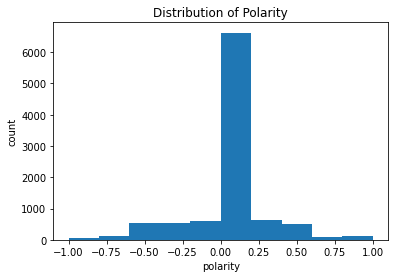

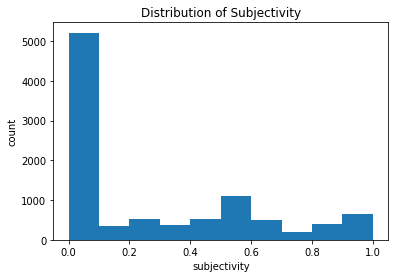

In [133]:
fig1, ax1 = plt.subplots()
ax1.set_xlabel('polarity')
ax1.set_ylabel('count') 
ax1.set_title('Distribution of Polarity')
ax1.hist(data['pattern_polarity'])

fig2,ax2 = plt.subplots()
ax2.set_xlabel('subjectivity')
ax2.set_ylabel('count')
ax2.set_title('Distribution of Subjectivity')
ax2.hist(data['pattern_subjectivity'])